# EIT2018 FECG & MECG detection based on Neural Network `V1.2`

Name: `Boyang Wang`                  

Date: `JAN 27 2018`


### To do list: 
 - getting data from matlab data, build the neural network, train for result.
 - this v1.1 use 1 set of mixture input as the training sample. 
 - in version 1.2, I am going to add two sets of input to train the neural network. hopefully it will be better

In [3]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
from shutil import copyfile
from tensorflow.contrib.tensorboard.plugins import projector
print ("PACKAGES LOADED")

PACKAGES LOADED


## Load data from `fecg_train_Input.mat`

The original data set has `fecg` , `mecg` , `mixture` , `train_input` , `train_label_fecg` , `train_label_mecg` , `train_label_nothing`

 - fecg (8, 15000)
 - mecg (8, 15000)
 - mixture (8, 15000)
 - sliced_mixture (8, 30, 14971)
 - train_label_fecg (14971, 2)
 - train_label_mecg (14971, 2)
 - train_label_nothing (14971, 2)

In [4]:
cwd = os.getcwd()
org_data = loadmat(cwd+'/dataset/fecg_train_input.mat')
fecg = org_data['fecg']
mecg = org_data['mecg']
mixture = org_data['mixture']
sliced_mixture = org_data['sliced_mixture']
train_label_fecg = org_data['train_label_fecg']
train_label_mecg = org_data['train_label_mecg']
train_label_nothing = org_data['train_label_nothing']
#print(train_label_fecg.shape)

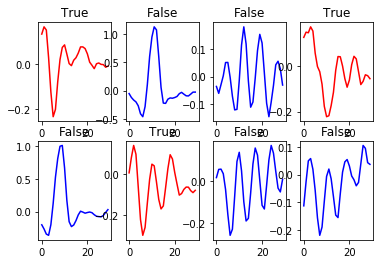

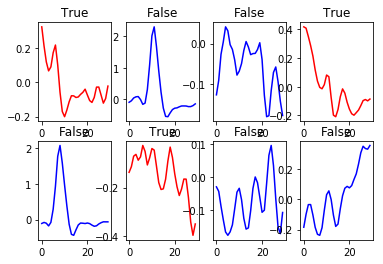

In [5]:
num = np.zeros(8)
for i in range(8):
    num[i] = random.randint(0,10000)
num = np.int_(num)

for i in range(8):
    plt.subplot(2, 4, i + 1)
    if train_label_fecg[num[i],0] == 1:
        plt.title('True')
        plt.plot(sliced_mixture[0,:,num[i]], 'r-')
    else:
        plt.title('False')
        plt.plot(sliced_mixture[0,:,num[i]], 'b-')
plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    if train_label_fecg[num[i],0] == 1:
        plt.title('True')
        plt.plot(sliced_mixture[1,:,num[i]], 'r-')
    else:
        plt.title('False')
        plt.plot(sliced_mixture[1,:,num[i]], 'b-')


## Prepare for the training input


In [6]:
train_input1 = sliced_mixture[0,:,0:10000].transpose()
train_input2 = sliced_mixture[1,:,0:10000].transpose()
train_input = np.concatenate((train_input1,train_input2),axis=1)

test_input1 = sliced_mixture[0,:,10000:14971].transpose()
test_input2 = sliced_mixture[1,:,10000:14971].transpose()
test_input = np.concatenate((train_input1,train_input2),axis=1)

train_label = train_label_fecg[0:10000,:]

ntrain = train_input.shape[0]
nclass = train_label.shape[1]
dim    = train_input.shape[1]

print(train_input.shape)
print(train_label.shape)

print ("%d train DATA loaded" % (ntrain))
print ("%d dimensional input" % (dim))
print ("%d class output" % (nclass))
print('Data loaded')

(10000, 60)
(10000, 2)
10000 train DATA loaded
60 dimensional input
2 class output
Data loaded


## Define MultiLayer Perception Network

Two hidden layer

hidden layer 1 : 100

hidden layer 2 : 50

In [7]:
tf.set_random_seed(0)
# Parameters
learning_rate   = 0.001
training_epochs = 4000
batch_size      = ntrain
display_step    = 400

# Network Parameters
n_hidden_1 = 100 # 1st layer num features
n_hidden_2 = 100 # 2nd layer num features
n_input    = dim # data input 
n_classes  = nclass # total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2']))
    return tf.matmul(layer_2, _weights['out']) + _biases['out']
    
# Store layers weight & bias
stddev = 0.1 # <== This greatly affects accuracy!! 
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=stddev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
print ("Network Ready to Go!")

Network Ready to Go!


In [9]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)
pred_softmax = y = tf.nn.softmax(pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y)) 
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
corr = tf.equal(tf.argmax(pred, axis = 1), tf.argmax(y, axis = 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# Initializing the variables
init = tf.global_variables_initializer()
print ("Functions ready")

Functions ready


In [10]:
# Launch the graph
sess = tf.Session()
sess.run(init)

# Summary writer
tf.summary.scalar('cross_entropy', cost)
tf.summary.scalar('accuracy', accr)
merged = tf.summary.merge_all()

LOG_DIR = os.path.join(cwd, 'logs_v1_2')
NAME_TO_VISUALISE_VARIABLE = "ultrasonic_embedding"
#PATH_TO_SPRITE_IMAGE = os.path.join(cwd, 'image/image.jpg')

summary_writer = tf.summary.FileWriter(LOG_DIR, graph=sess.graph)

# define embedding variable

buf = train_input
embedding_var = tf.Variable(buf,name=NAME_TO_VISUALISE_VARIABLE)

# Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# add one embedding
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(summary_writer, config)

sess.run(tf.variables_initializer([embedding_var]))

saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, 'model.ckpt'))
print ("Summary ready")

Summary ready


In [11]:
print(embedding_var)

<tf.Variable 'ultrasonic_embedding:0' shape=(10000, 60) dtype=float64_ref>


In [12]:
metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')
metadata = open(metadata_path, 'w')
metadata.write("Name\tType\n")
for i in range(0,10000):
    if(train_label[i,0]==0):
        metadata.write("0\tNOTHING\n")
    else:
        metadata.write("1\tFECG\n")
metadata.close()

In [13]:
# Training cycle
start = time.time()
#print(start)
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(ntrain/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size = batch_size)
        batch_xs = train_input[randidx, :]
        batch_ys = train_label[randidx, :] 
        # Fit training using batch data
        summary,_ = sess.run([merged, optm], feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch
        # Display logs per epoch step
        summary_writer.add_summary(summary, epoch*total_batch+i)
    if epoch % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
        print (" Training accuracy: %.3f" % (train_acc))
        #test_acc = sess.run(accr, feed_dict={x: test_input, y: test_label})
        #print (" Test accuracy: %.3f" % (test_acc))

print ("Optimization Finished!")
end = time.time()
#print(end)
text = 'Time elapsed: ' + str(end-start) + ' seconds'
print(text)

Epoch: 000/4000 cost: 1.432564378
 Training accuracy: 0.251
Epoch: 400/4000 cost: 0.096505433
 Training accuracy: 0.971
Epoch: 800/4000 cost: 0.026236072
 Training accuracy: 0.993
Epoch: 1200/4000 cost: 0.011004637
 Training accuracy: 0.998
Epoch: 1600/4000 cost: 0.005579186
 Training accuracy: 0.999
Epoch: 2000/4000 cost: 0.002477346
 Training accuracy: 1.000
Epoch: 2400/4000 cost: 0.001357760
 Training accuracy: 1.000
Epoch: 2800/4000 cost: 0.000690444
 Training accuracy: 1.000
Epoch: 3200/4000 cost: 0.000458151
 Training accuracy: 1.000
Epoch: 3600/4000 cost: 0.000234171
 Training accuracy: 1.000
Optimization Finished!
Time elapsed: 66.19360089302063 seconds


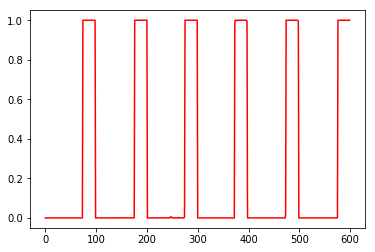

In [14]:
result = sess.run(pred_softmax, feed_dict={x: test_input})
plt.plot(result[0:600,0],'r-')

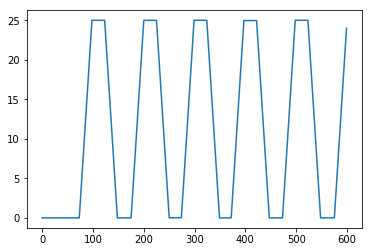

In [15]:
def process_output(raw_result):
    if(raw_result.shape[0] == 1999):
        processed_result = np.zeros(2048)
        #processed_result = raw_result
        for i in range(0,1999):
            processed_result[i:i+50] = processed_result[i:i+50] + 1*raw_result[i]
    else:
        print('input data not valid')
        return None
    return processed_result

test_random_idx = 0
raw_result = result[((test_random_idx) * 1999): ((test_random_idx+1) * 1999),0]
processed_data = process_output(raw_result)
plt.plot(processed_data[0:600])

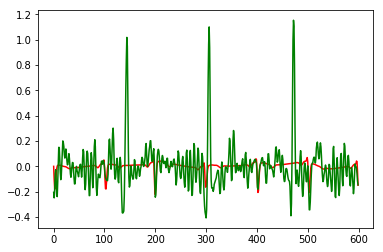

In [17]:
plt.plot(fecg[0,10000:10600],'r')
plt.plot(mixture[0,10000:10600],'g')


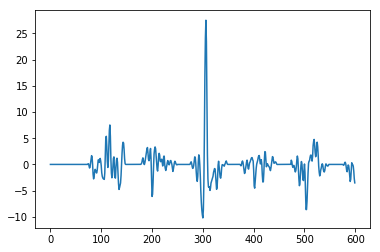

In [19]:
result = result[0:600]
datain = mixture[0,10000:10600]
multi = result * datain
plt.plot(multi)